# Disagreement in Crowdsourced Policymaking

##  Occurrence of Disagreement, Agreement, and Elaboration in Idea Generation (w/o moderation)

This notebook contains the statistical analyses conducted for the article *The Value of Disagreement in Crowdsourced Policymaking:Idea Generation Through Elaborated Perspectives*. The analyses aim at understanding how the occurrence of disagreement and agreement affects idea generation. The design of the analysis is presented below.

<img src="imgs/disagreement_crowdsourcing_deliberation_wo_mod.png">

## Content

- [Load libraries](#0.-Load-libraries)
- [Load data](#1.-Load-data)
- [Preprocess data](#2.-Preprocess-data)
- [Analysis: Step 1](#3.-Analysis:-Step-1)
- [Analysis: Step 2](#4.-Analysis:-Step-2)
- [Analysis: Step 3](#5.-Analysis:-Step-3)

## 0. Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from collections import defaultdict
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## 1. Load data

Data is distributed in three data files, each representing a discussion topic.

### Topic: Member decision making and right

In [2]:
member_df = pd.read_csv('data/member_decision_making_and_right.csv')
print(f'The dataset has {member_df.shape[0]} rows and {member_df.shape[1]} columns')

The dataset has 213 rows and 49 columns


### Topic: Administration of an association

In [3]:
admin_df = pd.read_csv('data/administration_of_association.csv')
print(f'The dataset has {admin_df.shape[0]} rows and {admin_df.shape[1]} columns')

The dataset has 119 rows and 49 columns


### Topic: Informally organized groups of an association

In [4]:
informal_df = pd.read_csv('data/informally_organized_group_of_a.csv')
print(f'The dataset has {informal_df.shape[0]} rows and {informal_df.shape[1]} columns')

The dataset has 159 rows and 51 columns


## 2. Preprocess data

### Normalize column names

Put column names to lower case, replace spaces with underscore, delete leading and trailing spaces, and remove non alpha-numerical characters

In [5]:
def normalize_column_names(names):
    names = names.str.lower()
    names = names.str.replace(' ','_')
    names = names.str.replace('.','_')
    names = names.str.replace('(','_')
    names = names.str.replace(')','')
    names = names.str.replace('/','_')
    names = names.str.replace('___','_')
    names = names.str.strip()
    return names

In [6]:
member_df.columns = normalize_column_names(member_df.columns)
admin_df.columns = normalize_column_names(admin_df.columns)
informal_df.columns = normalize_column_names(informal_df.columns)

### Standarize column names

Columns that contained the same information but have slightly different names are renamed for compatibility purposes

In [7]:
member_df = member_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades'
})

In [8]:
admin_df = admin_df.rename(columns={
    'amount_of_likes': 'number_of_likes',
    'comment\'s_id': 'comment_id',
    'proposal': 'proposals',    
})

In [9]:
informal_df = informal_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades',
    'proposal': 'proposals'
})

### Merge datasets in one dataframe

Add an extra column to indicate the discussion topic

In [10]:
member_df['topic'] = 'member'
admin_df['topic'] = 'admin'
informal_df['topic'] = 'informal'

#### Merge datasets

In [11]:
all_df = pd.concat([member_df, admin_df, informal_df], axis=0, ignore_index=True)
print(f'The merged dataset has {all_df.shape[0]} rows and {all_df.shape[1]} columns')

The merged dataset has 491 rows and 53 columns


### Remove columns containing text in Finnish

Text of comments and responses are both in Finnish and English. Columns `comment` and `response` that contain text in Finnish are removed because they will not be considered in this analysis.

In [12]:
all_df = all_df.drop(['comment', 'response'], axis=1)

Columns `comment_1` and `response_1` are renamed removing `_1` from their names

In [13]:
all_df = all_df.rename(columns={'comment_1': 'comment', 'response_1': 'response'})

### Check null values

Check the number of null values by columns

In [14]:
all_df.isnull().sum()

background                                          3
proposals                                           3
time                                                3
user_id                                             3
comment_id                                        346
response_id                                       148
number_of_likes                                     0
users_who_liked                                   263
attachments                                       491
comment                                           348
response                                          146
topic_1                                             4
topic_2                                           147
topic_3                                           358
disagreement                                        0
agreement                                           0
simple_disagreement                                 0
elaborated_disagreement                             0
simple_agreement            

### Remove summary rows

Remove rows that contain summaries. They are identified by having a null value in the column background.

In [15]:
idxs_to_remove = all_df[all_df.background.isnull()].index.values
all_df = all_df.drop(index=idxs_to_remove)
print(f'Data set size after removing summary rows. Rows: {all_df.shape[0]}, Columns: {all_df.shape[1]}')

Data set size after removing summary rows. Rows: 488, Columns: 51


### Fix errors in variables

There were labeling errors in the rows `336` and `310`; they are fixed below

In [16]:
all_df.loc[336, 'simple_agreement'] = 0
all_df.loc[310, 'elaborated_agreement'] = 1

### Fix values in the column `number_of_ideas`

In [17]:
all_df.loc[all_df['number_of_ideas']=='unclear', 'number_of_ideas'] = 0
all_df.loc[all_df['number_of_ideas'].isna(), 'number_of_ideas'] = 0
all_df['number_of_ideas'] = pd.to_numeric(all_df['number_of_ideas'], downcast='unsigned')

### Remove moderator comments

In [18]:
print(f'There are {len(all_df[all_df["moderator_post"]==1])} comments that will be removed')

There are 120 comments that will be removed


In [19]:
all_df = all_df[all_df['moderator_post']!=1]

### Show final columns

In [20]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'comment_id',
       'response_id', 'number_of_likes', 'users_who_liked', 'attachments',
       'comment', 'response', 'topic_1', 'topic_2', 'topic_3', 'disagreement',
       'agreement', 'simple_disagreement', 'elaborated_disagreement',
       'simple_agreement', 'elaborated_agreement', 'idea_s', 'number_of_ideas',
       'new_idea', 'sourcing', 'value_s', 'topic_shift', 'brainstorming',
       'blending', 'building', 'broadening', 'fact', 'value', 'policy',
       'interpretation', 'target_of_disagreement', 'target_of_agreement',
       'gives_reason_s', 'presents_evidence', 'asks_question_s',
       'provides_information', 'clarifies_position_stance',
       'responds_to_previous_comment', 'constructive_tone', 'moderator_post',
       'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrconstructive_tone'],
      dtype='object')

### Show a small sample

In [21]:
all_df.head()

,background,proposals,time,user_id,comment_id,response_id,number_of_likes,users_who_liked,attachments,comment,...,responds_to_previous_comment,constructive_tone,moderator_post,acknowledges_problem,notes,annotations_for_disagreement_new_idea_cascades,topic,irrpolicy,irrinterpretation,irrconstructive_tone
1,Members’ decision-making and rights\n\nIn this...,Proposal: Allow association members’ decision-...,2019-06-04T07:08:18+00:00,5cf60f17d8f1250a070160ee,NaN,5cf618e22878cf073b0eafca,1,karin.rinne@netti.fi,NaN,NaN,...,1,1,0,0,NaN,NaN,member,NaN,NaN,NaN
2,Members’ decision-making and rights\n\nIn this...,Proposal: Allow association members’ decision-...,2019-06-04T10:39:32+00:00,5cf6379534204f3a8d121027,NaN,5cf64a64d8f1253e5a242b5b,0,NaN,NaN,NaN,...,1,1,0,0,NaN,NaN,member,NaN,NaN,NaN
3,Members’ decision-making and rights\n\nIn this...,Proposal: Allow association members’ decision-...,2019-06-04T11:34:33+00:00,5cf63071d8f12537d5632b3e,NaN,5cf657492878cf36b01b767b,0,NaN,NaN,NaN,...,1,1,0,1,NaN,NaN,member,NaN,NaN,NaN
7,Members’ decision-making and rights\n\nIn this...,Proposal: Allow association members’ decision-...,2019-06-04T16:31:27+00:00,5cf63071d8f12537d5632b3e,NaN,5cf69cdfd8f12530a35e8e7c,2,"arto.paeivinen@gmail.com,stina.koivisto@eslu.fi",NaN,NaN,...,1,1,0,1,NaN,NaN,member,NaN,NaN,NaN
9,Members’ decision-making and rights\n\nIn this...,Proposal: Allow association members’ decision-...,2019-06-07T12:01:58+00:00,5cf63071d8f12537d5632b3e,NaN,5cfa52362878cf5c9946913f,0,NaN,NaN,NaN,...,1,1,0,0,NaN,NaN,member,NaN,NaN,NaN


### Show final dataset dimesion

In [22]:
print(f'The final dataset has a dimension of {all_df.shape[0]} rows and {all_df.shape[1]} columns')

The final dataset has a dimension of 368 rows and 51 columns


## 3. Analysis: Step 1

In the first step of the analysis, the mean of ideas in comments with neither agreement nor disagreement is compared against the mean of ideas in comments with agreement and/or disagreement. The statistical significance of the mean difference is evaluated.

### Define alpha level

In [23]:
alpha_level = 0.05

### Split dataset

The dataset is divided in two smaller datasets that are going to be used in the analysis.

#### Comments with neither agreement nor disagreement

In [24]:
n_dis_n_agg = all_df[(all_df['disagreement']==0)&(all_df['agreement']==0)]
print(f'There are {n_dis_n_agg.shape[0]} comments with neither agreement and disagreement')

There are 44 comments with neither agreement and disagreement


Descriptive stats regarding **`number of ideas`**

In [25]:
round(n_dis_n_agg['number_of_ideas'].describe(),3)

count    44.000
mean      1.295
std       0.930
min       0.000
25%       1.000
50%       1.000
75%       2.000
max       4.000
Name: number_of_ideas, dtype: float64

Histogram

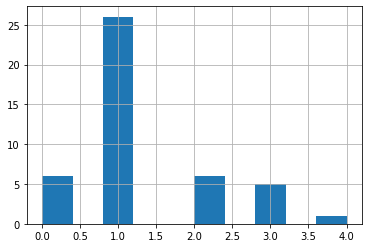

In [26]:
n_dis_n_agg['number_of_ideas'].hist()

#### Comments with agreement and/or disagreement

In [27]:
dis_agg = all_df[(all_df['disagreement']!=0)|(all_df['agreement']!=0)]
print(f'There are {dis_agg.shape[0]} comments with agreement and/or disagreement')

There are 324 comments with agreement and/or disagreement


Descriptive stats regarding **`number of ideas`**

In [28]:
round(dis_agg['number_of_ideas'].describe(),3)

count    324.000
mean       1.679
std        1.111
min        0.000
25%        1.000
50%        1.000
75%        2.000
max        8.000
Name: number_of_ideas, dtype: float64

Histogram

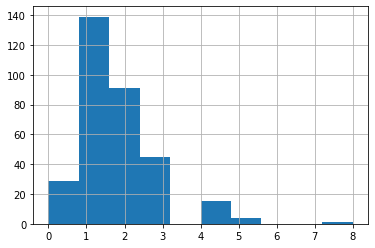

In [29]:
dis_agg['number_of_ideas'].hist()

### Analysis

Given that the distributions of ideas in samples do not follow a normal distribution the non-parametric test [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) is used.

In [30]:
stat, p_val = stats.mannwhitneyu(n_dis_n_agg['number_of_ideas'], dis_agg['number_of_ideas'])

In [31]:
if p_val < alpha_level:
    print(f'The difference in the number of ideas between sets is statistically significance, p-value={p_val}')

The difference in the number of ideas between sets is statistically significance, p-value=0.00886603758555911


### Results

Comments in which disagreement and/or agreement occur show to have a statistically significant larger number of ideas than comments with neither agreement nor disagreement.

## 4. Analysis: Step 2

In the second step of the analysis, comments with agreement and/or disagreement is divided into three sets, namely, comments with only agreement, comments only disagreement, and comments both agreement and disagreement. The mean of ideas in each set is compared and the statistical significance of the mean difference is evaluated.

### Define alpha level

In [32]:
alpha_level = 0.05

### Split dataset

#### Comments with only agreement

In [33]:
agg = dis_agg[(dis_agg['disagreement']==0)&(dis_agg['agreement']==1)]
print(f'There are {agg.shape[0]} comments with only agreement')

There are 98 comments with only agreement


Descriptive stats regarding **`number of ideas`**

In [34]:
round(agg['number_of_ideas'].describe(),3)

count    98.000
mean      1.439
std       1.332
min       0.000
25%       1.000
50%       1.000
75%       2.000
max       8.000
Name: number_of_ideas, dtype: float64

Histogram

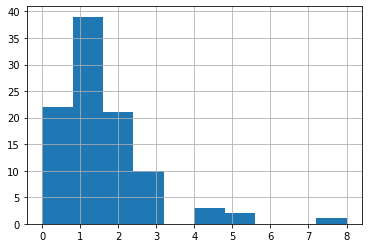

In [35]:
agg['number_of_ideas'].hist()

#### Comments with only disagreement

In [36]:
dis = dis_agg[(dis_agg['disagreement']==1)&(dis_agg['agreement']==0)]
print(f'There are {dis.shape[0]} comments with only disagreement')

There are 130 comments with only disagreement


Descriptive stats regarding **`number of ideas`**

In [37]:
round(dis['number_of_ideas'].describe(),3)

count    130.000
mean       1.615
std        0.927
min        0.000
25%        1.000
50%        1.000
75%        2.000
max        5.000
Name: number_of_ideas, dtype: float64

Histogram

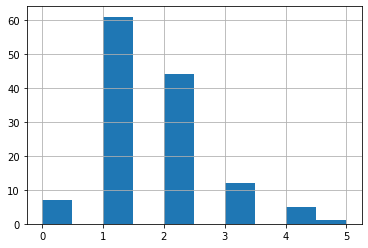

In [38]:
dis['number_of_ideas'].hist()

#### Comments with both agreement and disagreement

In [39]:
both_dis_agg = dis_agg[(dis_agg['disagreement']==1)&(dis_agg['agreement']==1)]
print(f'There are {both_dis_agg.shape[0]} comments with both agreement and disagreement')

There are 96 comments with both agreement and disagreement


Descriptive stats regarding **`number of ideas`**

In [40]:
round(both_dis_agg['number_of_ideas'].describe(),3)

count    96.000
mean      2.010
std       1.021
min       1.000
25%       1.000
50%       2.000
75%       3.000
max       5.000
Name: number_of_ideas, dtype: float64

Histogram

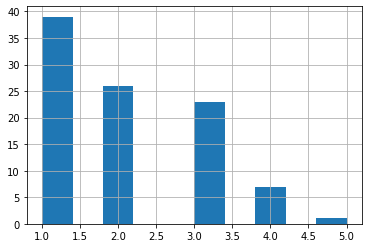

In [41]:
both_dis_agg['number_of_ideas'].hist()

### Analysis

Given that the distributions of ideas in samples do not follow a normal distribution the non-parametric test [Kruskal-Wallis one-way ANOVA](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is used.

In [42]:
stat, p_val = stats.kruskal(agg['number_of_ideas'], dis['number_of_ideas'], both_dis_agg['number_of_ideas'])

In [43]:
if p_val < alpha_level:
    print(f'The difference in the number of ideas between sets is statistically significance, p-value={p_val}')

The difference in the number of ideas between sets is statistically significance, p-value=8.139497573431767e-05


#### Post hoc Test

To conduct the poshoc analysis, data need to be transformed.

In [44]:
posthoc_df = pd.DataFrame({
    'group': np.repeat(['agg'], repeats=agg.shape[0]), 
    'number_of_ideas': agg['number_of_ideas']}
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['dis'], repeats=dis.shape[0]), 
        'number_of_ideas': dis['number_of_ideas']})
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['both_dis_agg'], repeats=both_dis_agg.shape[0]), 
        'number_of_ideas': both_dis_agg['number_of_ideas']
    })
)

[Tukey test](https://en.wikipedia.org/wiki/Tukey%27s_range_test) is employed to find out which specific set's means (compared with each other) is statistically different.

In [45]:
tukey = pairwise_tukeyhsd(endog=posthoc_df['number_of_ideas'], groups=posthoc_df['group'], alpha=alpha_level)

In [46]:
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
         agg both_dis_agg   0.5716  0.001  0.2028  0.9405   True
         agg          dis   0.1766 0.4498  -0.167  0.5202  False
both_dis_agg          dis   -0.395 0.0204 -0.7407 -0.0494   True
----------------------------------------------------------------


### Results

Comments in which both disagreement and agreement are present show to have a statistically significant larger number of ideas than comments with only agreement. The same is true for comments with both disagreement and agreement and comments with only disagreement.

## 5. Analysis: Step 3

In the third step of the analysis, it is studied how the type agreement and disagreement (simple, elaborated) influence the generation of ideas. In doing so, comments with only agreement are split in two sets, comments with only simple agreement and comments with only elaborated agreement. Similarly comments with only disagreement are divided. Comments with both agreement and disagreement are split in four sets, comments with both simple agreement and simple disagreement, comments with simple agreement and elaborated disagreement, comments with elaborated agreement and simple disagreement, and comments with elaborated agreement and elaborated disagreement. The mean of ideas in each set is compared and the statistical significance of the mean difference is evaluated.

### Define alpha level

In [58]:
alpha_level = 0.05

### Split dataset

#### Comments with only simple agreement

In [47]:
simple_agg = agg[(agg['simple_agreement']==1)&(agg['elaborated_agreement']==0)]
print(f'There are {simple_agg.shape[0]} comments with only simple agreement')

There are 29 comments with only simple agreement


Descriptive stats regarding **`number of ideas`**

In [48]:
round(simple_agg['number_of_ideas'].describe(),3)

count    29.000
mean      0.310
std       0.604
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       2.000
Name: number_of_ideas, dtype: float64

Histogram

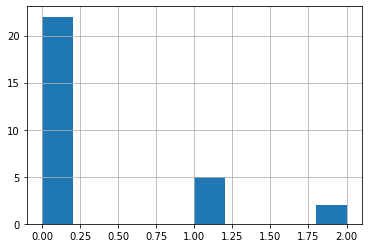

In [49]:
simple_agg['number_of_ideas'].hist()

#### Comments with only elaborated agreement

In [50]:
elaborated_agg = agg[(agg['simple_agreement']==0)&(agg['elaborated_agreement']==1)]
print(f'There are {elaborated_agg.shape[0]} comments with only elaborated agreement')

There are 69 comments with only elaborated agreement


Descriptive stats regarding **`number of ideas`**

In [51]:
round(elaborated_agg['number_of_ideas'].describe(),3)

count    69.000
mean      1.913
std       1.269
min       1.000
25%       1.000
50%       2.000
75%       2.000
max       8.000
Name: number_of_ideas, dtype: float64

Histogram

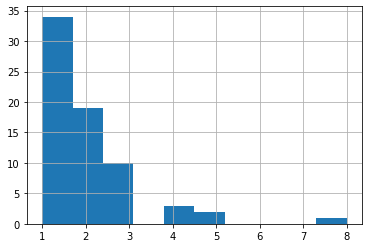

In [52]:
elaborated_agg['number_of_ideas'].hist()

#### Comments with only simple disagreement

In [53]:
simple_dis = dis[(dis['simple_disagreement']==1)&(dis['elaborated_disagreement']==0)]
print(f'There are {simple_dis.shape[0]} comments with only simple disagreement')

There are 18 comments with only simple disagreement


Descriptive stats regarding **`number of ideas`**

In [54]:
round(simple_dis['number_of_ideas'].describe(),3)

count    18.000
mean      0.722
std       0.461
min       0.000
25%       0.250
50%       1.000
75%       1.000
max       1.000
Name: number_of_ideas, dtype: float64

Histogram

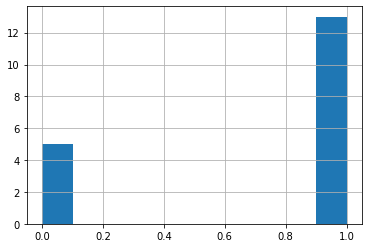

In [55]:
simple_dis['number_of_ideas'].hist()

#### Comments with only elaborated disagreement

In [56]:
elaborated_dis = dis[(dis['simple_disagreement']==0)&(dis['elaborated_disagreement']==1)]
print(f'There are {elaborated_dis.shape[0]} comments with only elaborated disagreement')

There are 112 comments with only elaborated disagreement


Descriptive stats regarding **`number of ideas`**

In [57]:
round(elaborated_dis['number_of_ideas'].describe(),3)

count    112.000
mean       1.759
std        0.903
min        0.000
25%        1.000
50%        2.000
75%        2.000
max        5.000
Name: number_of_ideas, dtype: float64

Histogram

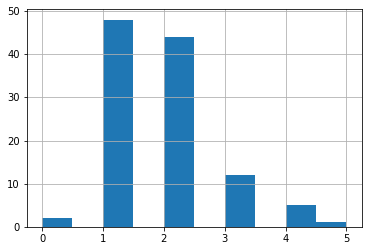

In [58]:
elaborated_dis['number_of_ideas'].hist()

#### Comments with simple agreement and simple disagreement

In [59]:
simple_dis_simple_agg = both_dis_agg[
    (both_dis_agg['simple_disagreement']==1)&
    (both_dis_agg['elaborated_disagreement']==0)&
    (both_dis_agg['simple_agreement']==1)&
    (both_dis_agg['elaborated_agreement']==0)
]
print(f'There are {simple_dis_simple_agg.shape[0]} comments with simple agreement and simple disagreement')

There are 5 comments with simple agreement and simple disagreement


Descriptive stats regarding **`number of ideas`**

In [60]:
round(simple_dis_simple_agg['number_of_ideas'].describe(),3)

count    5.000
mean     1.200
std      0.447
min      1.000
25%      1.000
50%      1.000
75%      1.000
max      2.000
Name: number_of_ideas, dtype: float64

Histogram

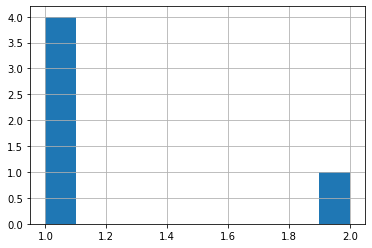

In [61]:
simple_dis_simple_agg['number_of_ideas'].hist()

#### Comments with simple agreement and elaborated disagreement

In [62]:
elaborate_dis_simple_agg = both_dis_agg[
    (both_dis_agg['simple_disagreement']==0)&
    (both_dis_agg['elaborated_disagreement']==1)&
    (both_dis_agg['simple_agreement']==1)&
    (both_dis_agg['elaborated_agreement']==0)
]
print(f'There are {elaborate_dis_simple_agg.shape[0]} comments with simple agreement and elaborated disagreement')

There are 13 comments with simple agreement and elaborated disagreement


Descriptive stats regarding **`number of ideas`**

In [63]:
round(elaborate_dis_simple_agg['number_of_ideas'].describe(),3)

count    13.000
mean      1.462
std       0.776
min       1.000
25%       1.000
50%       1.000
75%       2.000
max       3.000
Name: number_of_ideas, dtype: float64

Histogram

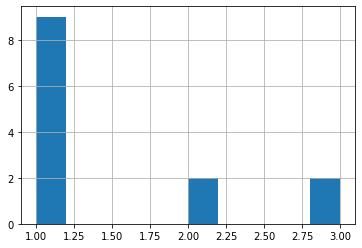

In [64]:
elaborate_dis_simple_agg['number_of_ideas'].hist()

#### Comments with elaborated agreement and simple disagreement

In [65]:
simple_dis_elaborate_agg = both_dis_agg[
    (both_dis_agg['simple_disagreement']==1)&
    (both_dis_agg['elaborated_disagreement']==0)&
    (both_dis_agg['simple_agreement']==0)&
    (both_dis_agg['elaborated_agreement']==1)
]
print(f'There are {simple_dis_elaborate_agg.shape[0]} comments with elaborated agreement and simple disagreement')

There are 0 comments with elaborated agreement and simple disagreement


#### Comments with elaborated agreement and elaborated disagreement

In [66]:
elaborated_dis_elaborated_agg = both_dis_agg[
    (both_dis_agg['simple_disagreement']==0)&
    (both_dis_agg['elaborated_disagreement']==1)&
    (both_dis_agg['simple_agreement']==0)&
    (both_dis_agg['elaborated_agreement']==1)
]
print(f'There are {elaborated_dis_elaborated_agg.shape[0]} comments with elaborated agreement and elaborated disagreement')

There are 78 comments with elaborated agreement and elaborated disagreement


Descriptive stats regarding **`number of ideas`**

In [67]:
round(elaborated_dis_elaborated_agg['number_of_ideas'].describe(),3)

count    78.000
mean      2.154
std       1.033
min       1.000
25%       1.000
50%       2.000
75%       3.000
max       5.000
Name: number_of_ideas, dtype: float64

Histogram

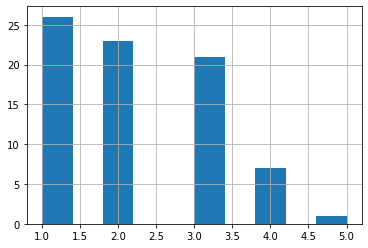

In [68]:
elaborated_dis_elaborated_agg['number_of_ideas'].hist()

### Analysis

Given that the distributions of ideas in samples do not follow a normal distribution the non-parametric test [Kruskal-Wallis one-way ANOVA](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is used. Only the subgroup of comments featuring both elaborated disagreement and elaborated agreement was large enough to include in the analysis.

In [69]:
stat, p_val = stats.kruskal(
    simple_agg['number_of_ideas'], 
    elaborated_agg['number_of_ideas'],
    simple_dis['number_of_ideas'], 
    elaborated_dis['number_of_ideas'], 
    elaborated_dis_elaborated_agg['number_of_ideas']
)

In [70]:
if p_val < alpha_level:
    print(f'The difference in the number of ideas between sets is statistically significance, p-value={p_val}')

The difference in the number of ideas between sets is statistically significance, p-value=4.406875247614016e-18


#### Post hoc Test

To conduct the poshoc analysis, data need to be transformed.

In [71]:
posthoc_df = pd.DataFrame({
    'group': np.repeat(['simple_agg'], repeats=simple_agg.shape[0]), 
    'number_of_ideas': simple_agg['number_of_ideas']}
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['simple_dis'], repeats=simple_dis.shape[0]), 
        'number_of_ideas': simple_dis['number_of_ideas']})
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['elaborated_agg'], repeats=elaborated_agg.shape[0]), 
        'number_of_ideas': elaborated_agg['number_of_ideas']})
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['elaborated_dis'], repeats=elaborated_dis.shape[0]), 
        'number_of_ideas': elaborated_dis['number_of_ideas']})
)
posthoc_df = posthoc_df.append(
    pd.DataFrame({
        'group': np.repeat(['elaborated_dis_elaborated_agg'], repeats=elaborated_dis_elaborated_agg.shape[0]), 
        'number_of_ideas': elaborated_dis_elaborated_agg['number_of_ideas']
    })
)

[Tukey test](https://en.wikipedia.org/wiki/Tukey%27s_range_test) is employed to find out which specific set's means (compared with each other) is statistically different.

In [72]:
tukey = pairwise_tukeyhsd(endog=posthoc_df['number_of_ideas'], groups=posthoc_df['group'], alpha=alpha_level)

In [73]:
print(tukey)

                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
            group1                        group2            meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------
               elaborated_agg                elaborated_dis  -0.1541 0.8288 -0.5706  0.2623  False
               elaborated_agg elaborated_dis_elaborated_agg   0.2408 0.5721 -0.2089  0.6905  False
               elaborated_agg                    simple_agg  -1.6027  0.001 -2.2049 -1.0005   True
               elaborated_agg                    simple_dis  -1.1908  0.001  -1.911 -0.4706   True
               elaborated_dis elaborated_dis_elaborated_agg   0.3949 0.0562 -0.0064  0.7962  False
               elaborated_dis                    simple_agg  -1.4486  0.001 -2.0156 -0.8816   True
               elaborated_dis                    simple_dis  -1.0367  0.001 -1.7277 -0.3457   True
elaborated

### Results

Comments in which both elaborated disagreement and elaborated agreement are present show to have statistically significant larger number of ideas than comments with simple agreement and than comments with simple disagreemment. Comments with elaborated agreement have statistically significant larger number of ideas than comment with simple agreement and than comments with simple disagreement. Similarly, comment with elaborated disagreement have statistically significant larger number of ideas than comments simple agreement and than comments with simple disagreement.
